# Advanced Machine Learning Models in PySpark

This notebook implements multiple classification models using PySpark with random search hyperparameter optimization.

## Table of Contents
1. [Model Selection Configuration](#1.-Model-Selection-Configuration)
2. [Importing Libraries](#2.-Importing-Libraries)
3. [Loading and Preprocessing Data](#3.-Loading-and-Preprocessing-Data)
4. [Helper Functions](#4.-Helper-Functions)
    - [4.1 Random Search Function](#4.1-Random-Search-Function)
    - [4.2 Evaluation Functions](#4.2-Evaluation-Functions)
5. [Model Training](#5.-Model-Training)
    - [5.2 Random Forest](#5.2-Random-Forest)
6. [Model Comparison](#6.-Model-Comparison)
7. [Test Set Evaluation](#7.-Test-Set-Evaluation-with-Best-Model)
8. [Conclusion](#8.-Conclusion)

## 1. Model Selection Configuration

**Set to True for models you want to train, False for models to skip.**

In [0]:
# Model selection configuration - Set to True to run, False to skip
RUN_MODELS = {
    'logistic_regression': False,
    'random_forest': True,
    'gbdt': False,
    'mlp': False,
    'xgboost': False
}

# Random search configuration
RANDOM_SEARCH_CONFIG = {
    'num_folds': 3,      
    'parallelism': 1     
}

# File paths configuration
DATA_PATHS = {
     'train': "/FileStore/tables/train_df__1_-1.csv",
     'val': "/FileStore/tables/val_df__1_-1.csv",
     'test': "/FileStore/tables/test_df__1_-2.csv"
 }
'''
DATA_PATHS = {
    'train': "/FileStore/tables/train_df__1_.csv",
    'val': "dbfs:/FileStore/tables/val_df__1_.csv",
    'test': "dbfs:/FileStore/tables/test_df__1_.csv"
}'''

Out[1]: '\nDATA_PATHS = {\n    \'train\': "/FileStore/tables/train_df__1_.csv",\n    \'val\': "dbfs:/FileStore/tables/val_df__1_.csv",\n    \'test\': "dbfs:/FileStore/tables/test_df__1_.csv"\n}'

## 2. Importing Libraries

In [0]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from math import ceil
import time
import os

# PySpark imports
from pyspark.sql import SparkSession  
from pyspark.sql.window import Window
from pyspark.sql.functions import col, row_number, when, lit, count, lag, expr
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType, ArrayType, FloatType

# ML imports for classification
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, MultilayerPerceptronClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.mllib.evaluation import MulticlassMetrics
import xgboost as xgb

# Scikit-learn imports for metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve

# Initialize Spark session
spark = SparkSession.builder.appName("ML Models Spark").getOrCreate()

XGBoost is available


## 3. Loading and Preprocessing Data

In [0]:
def load_and_preprocess_data(file_paths):
    """Load and preprocess data from specified file paths.
    
    Args:
        file_paths (dict): Dictionary with keys 'train', 'val', 'test' and file path values
        
    Returns:
        tuple: Preprocessed train, validation, and test data
    """
    # Load data
    train_data = spark.read.csv(file_paths['train'], header=True, inferSchema=True)
    val_data = spark.read.csv(file_paths['val'], header=True, inferSchema=True)
    test_data = spark.read.csv(file_paths['test'], header=True, inferSchema=True)
    
    # Select feature columns (all except 'label', 'time', and 'file')
    feature_cols = [col for col in train_data.columns if col not in ['label', 'time', 'file']]
    
    # Assemble features into a single vector column
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
    train_data = assembler.transform(train_data).select("features", "label")
    val_data = assembler.transform(val_data).select("features", "label")
    test_data = assembler.transform(test_data).select("features", "label")
    
    print(f"Data loaded and preprocessed:")
    print(f"  - Training samples: {train_data.count()}")
    print(f"  - Validation samples: {val_data.count()}")
    print(f"  - Test samples: {test_data.count()}")
    
    return train_data, val_data, test_data

# Load and preprocess the data
train_data, val_data, test_data = load_and_preprocess_data(DATA_PATHS)

# Display a few samples
print("\nSample of training data:")
train_data.show(3)

# Count classes
num_classes = train_data.select("label").distinct().count()
print(f"\nNumber of classes: {num_classes}")

Data loaded and preprocessed:
  - Training samples: 3142910
  - Validation samples: 681381
  - Test samples: 681395

Sample of training data:
+--------------------+-----+
|            features|label|
+--------------------+-----+
|[-1.611721611721E...|    0|
|[1.95360195360194...|    0|
|[-9.7680097680097...|    0|
+--------------------+-----+
only showing top 3 rows


Number of classes: 3


## 4. Helper Functions

### 4.1 Random Search Function

In [0]:
def perform_random_search(model, param_grid, train_data, val_data, num_folds=3, parallelism=2):
    """Perform random search for hyperparameter tuning of a model.
    
    Args:
        model: Machine learning model instance
        param_grid: Parameter grid for random search
        train_data: Training data DataFrame
        val_data: Validation data DataFrame
        num_folds: Number of cross-validation folds
        parallelism: Number of parallel tasks
        
    Returns:
        tuple: (best_model, best_params, train_predictions, val_predictions, train_f1, val_f1)
    """
    # Initialize the evaluator for F1 score
    evaluator = MulticlassClassificationEvaluator(
        labelCol='label', 
        predictionCol='prediction', 
        metricName='f1'
    )
    
    # Initialize CrossValidator for hyperparameter tuning
    cv = CrossValidator(
        estimator=model,
        estimatorParamMaps=param_grid,
        evaluator=evaluator,
        numFolds=num_folds,
        parallelism=parallelism
    )
    
    # Start timing
    start_time = time.time()
    
    # Fit the cross-validator to the training data
    print("Training model with random search...")
    cv_model = cv.fit(train_data)
    
    # End timing
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds")
    
    # Extract the best model
    best_model = cv_model.bestModel
    
    # Get best parameters
    best_params = {}
    for param in best_model.extractParamMap():
        param_name = param.name
        param_value = best_model.getOrDefault(param)
        best_params[param_name] = param_value
    
    # Make predictions with the best model
    train_predictions = best_model.transform(train_data)
    val_predictions = best_model.transform(val_data)
    
    # Calculate F1 scores
    train_f1 = evaluator.evaluate(train_predictions)
    val_f1 = evaluator.evaluate(val_predictions)
    
    return best_model, best_params, train_predictions, val_predictions, train_f1, val_f1


### 4.2 Evaluation Functions

In [0]:
# Helper function to convert PySpark predictions to numpy arrays for plotting
def get_prediction_labels(predictions_df):
    """Extract prediction and label columns from PySpark DataFrame."""
    pred_labels = predictions_df.select("prediction", "label").toPandas()
    y_pred = pred_labels["prediction"].values
    y_true = pred_labels["label"].values
    return y_pred, y_true

# Helper function to get prediction probabilities
def get_prediction_probabilities(predictions_df):
    """Extract probability column from PySpark DataFrame."""
    prob_df = predictions_df.select("probability").toPandas()
    return np.array([x.toArray() for x in prob_df["probability"]])

# Helper function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    """Plot confusion matrix using seaborn."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Helper function to print classification report
def print_classification_report(y_true, y_pred):
    """Print classification report with precision, recall, and F1 scores."""
    report = classification_report(y_true, y_pred)
    print("Classification Report:")
    print(report)

# Helper function to plot ROC curve for multi-class

def plot_roc_curve(y_true, y_pred_proba, n_classes, model_name="Model"):
    """Plot ROC curve for multi-class classification and export points to CSV + FileStore."""
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    roc_data = []

    # One-hot encoding
    y_true_onehot = np.zeros((len(y_true), n_classes))
    for i in range(len(y_true)):
        y_true_onehot[i, int(y_true[i])] = 1

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_onehot[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        for j in range(len(fpr[i])):
            roc_data.append({
                "Modelo": model_name,
                "Classe": i,
                "FPR": fpr[i][j],
                "TPR": tpr[i][j]
            })


    # Plot
    plt.figure(figsize=(10, 8))
    colors = ['blue', 'red', 'green', 'orange', 'purple']
    for i, color in zip(range(n_classes), colors[:n_classes]):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of class {i} (area = {roc_auc[i]:0.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

    return np.mean(list(roc_auc.values()))

# Helper function to plot precision-recall curve
def plot_precision_recall_curve(y_true, y_pred_proba, n_classes, model_name="Model"):
    """Plot Precision-Recall curve and export points to CSV + FileStore."""
    precision = dict()
    recall = dict()
    avg_precision = dict()
    pr_data = []

    # One-hot encoding
    y_true_onehot = np.zeros((len(y_true), n_classes))
    for i in range(len(y_true)):
        y_true_onehot[i, int(y_true[i])] = 1

    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_true_onehot[:, i], y_pred_proba[:, i])
        avg_precision[i] = np.mean(precision[i])
        for j in range(len(precision[i])):
            pr_data.append({
                "Modelo": model_name,
                "Classe": i,
                "Recall": recall[i][j],
                "Precision": precision[i][j]
            })

    # Plot
    plt.figure(figsize=(10, 8))
    colors = ['blue', 'red', 'green', 'orange', 'purple']
    for i, color in zip(range(n_classes), colors[:n_classes]):
        plt.plot(recall[i], precision[i], color=color, lw=2,
                 label=f'Class {i} (avg precision = {avg_precision[i]:0.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Multi-class Precision-Recall Curve')
    plt.legend(loc="best")
    plt.show()

    return np.mean(list(avg_precision.values()))

def evaluate_model(model_name, val_predictions, num_classes, has_probability=True):
    """Perform comprehensive evaluation of a model.
    
    Args:
        model_name: Name of the model
        val_predictions: PySpark DataFrame with predictions
        num_classes: Number of classes
        has_probability: Whether the model outputs probability scores
        
    Returns:
        tuple: (y_pred, y_true, y_pred_proba)
    """
    print(f"\n--- {model_name} Evaluation ---")
    
    # Extract predictions and true labels
    y_pred, y_true = get_prediction_labels(val_predictions)
    
    # Plot confusion matrix
    print("\nConfusion Matrix:")
    plot_confusion_matrix(y_true, y_pred, f"{model_name} Confusion Matrix")
    
    # Print classification report
    print(f"\n{model_name} Classification Report:")
    print_classification_report(y_true, y_pred)
    
    # If model has probability outputs, plot ROC and PR curves
    y_pred_proba = None
    if has_probability:
        y_pred_proba = get_prediction_probabilities(val_predictions)
        
        # Plot ROC curve
        print("\nROC Curve:")
        auc_score = plot_roc_curve(y_true, y_pred_proba, num_classes, model_name)        
        print(f"{model_name} Average AUC: {auc_score:.4f}")
        
        # Plot Precision-Recall curve
        print("\nPrecision-Recall Curve:")
        avg_precision = plot_precision_recall_curve(y_true, y_pred_proba, num_classes, model_name)
        print(f"{model_name} Average Precision: {avg_precision:.4f}")
    
    return y_pred, y_true, y_pred_proba

## 5. Model Training

### 5.2 Random Forest


==== Random Forest Model ====
Training model with random search...
Training completed in 2981.85 seconds

Best Random Forest Parameters:
  bootstrap: True
  cacheNodeIds: False
  checkpointInterval: 10
  featureSubsetStrategy: auto
  featuresCol: features
  impurity: gini
  labelCol: label
  leafCol: 
  maxBins: 32
  maxDepth: 10
  maxMemoryInMB: 256
  minInfoGain: 0.0
  minInstancesPerNode: 3
  minWeightFractionPerNode: 0.0
  numTrees: 20
  predictionCol: prediction
  probabilityCol: probability
  rawPredictionCol: rawPrediction
  seed: -5387697053847413545
  subsamplingRate: 1.0

Random Forest - Training F1 Score: 0.9291
Random Forest - Validation F1 Score: 0.8858

--- Random Forest Evaluation ---

Confusion Matrix:


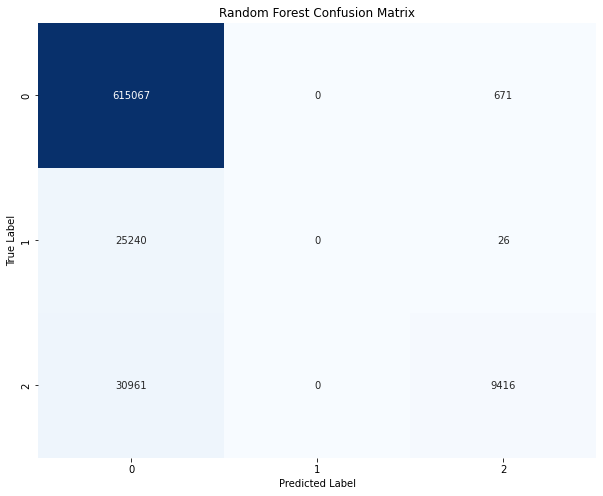


Random Forest Classification Report:


/databricks/python/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/databricks/python/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/databricks/python/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/databricks/spark/python/pyspark/sql/pandas

Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96    615738
           1       0.00      0.00      0.00     25266
           2       0.93      0.23      0.37     40377

    accuracy                           0.92    681381
   macro avg       0.62      0.41      0.44    681381
weighted avg       0.88      0.92      0.89    681381


ROC Curve:


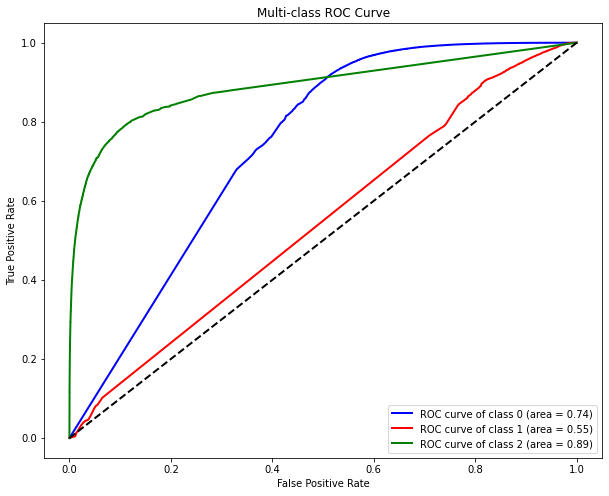

Random Forest Average AUC: 0.7252

Precision-Recall Curve:


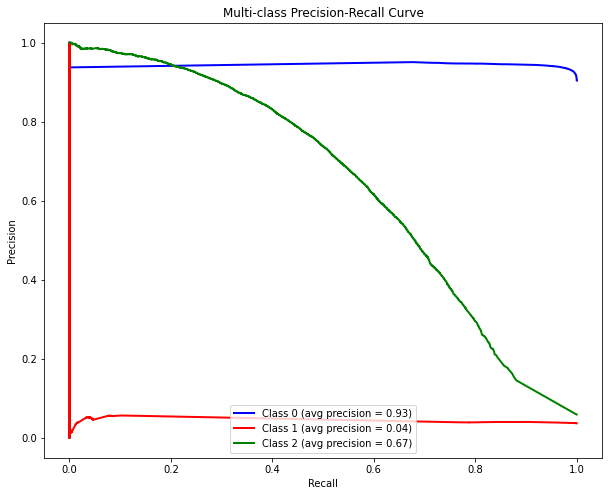

Random Forest Average Precision: 0.5472


In [0]:
if RUN_MODELS['random_forest']:
    print("\n==== Random Forest Model ====")
    
    # Initialize Random Forest Classifier
    rf = RandomForestClassifier(labelCol="label", featuresCol="features")
    
    # Define parameter grid for Random Forest
    rf_param_grid = ParamGridBuilder() \
        .addGrid(rf.maxDepth, [6, 10]) \
        .addGrid(rf.impurity, ["gini"]) \
        .addGrid(rf.minInstancesPerNode, [1, 3]) \
        .build()
    
    # Perform random search
    rf_best_model, rf_best_params, rf_train_preds, rf_val_preds, rf_train_f1, rf_val_f1 = perform_random_search(
        rf, 
        rf_param_grid, 
        train_data, 
        val_data, 
        num_folds=RANDOM_SEARCH_CONFIG['num_folds'],
        parallelism=RANDOM_SEARCH_CONFIG['parallelism']
    )
    
    # Print best parameters and performance
    print("\nBest Random Forest Parameters:")
    for param, value in rf_best_params.items():
        print(f"  {param}: {value}")
    
    print(f"\nRandom Forest - Training F1 Score: {rf_train_f1:.4f}")
    print(f"Random Forest - Validation F1 Score: {rf_val_f1:.4f}")
    
    # Run comprehensive evaluation
    rf_y_pred, rf_y_true, rf_y_pred_proba = evaluate_model("Random Forest", rf_val_preds, num_classes)
else:
    print("Skipping Random Forest")

## 7. Test Set Evaluation

Best Model: Random Forest with Validation F1: 0.8858
Test F1 Score with Random Forest: 0.8412

--- Random Forest Test Set Evaluation ---

--- Random Forest (Test) Evaluation ---

Confusion Matrix:


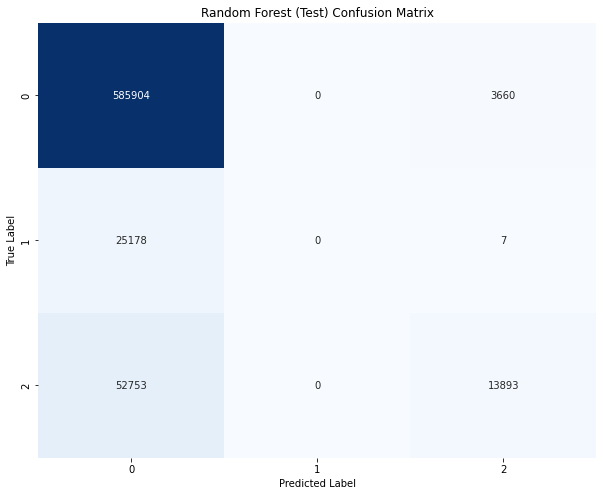


Random Forest (Test) Classification Report:


/databricks/python/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/databricks/python/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/databricks/python/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.99      0.93    589564
           1       0.00      0.00      0.00     25185
           2       0.79      0.21      0.33     66646

    accuracy                           0.88    681395
   macro avg       0.56      0.40      0.42    681395
weighted avg       0.84      0.88      0.84    681395



/databricks/spark/python/pyspark/sql/pandas/conversion.py:122: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field probability. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)



ROC Curve:


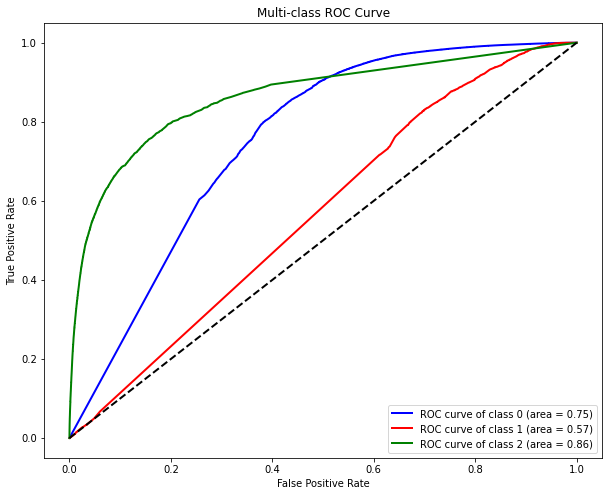

Random Forest (Test) Average AUC: 0.7286

Precision-Recall Curve:


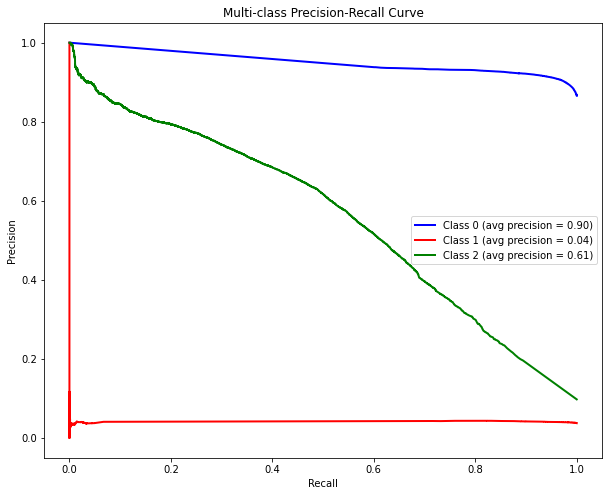

Random Forest (Test) Average Precision: 0.5192


In [0]:
if model_names:  
    # Find the best model based on validation F1 scores
    best_model_index = val_scores.index(max(val_scores))
    best_model_name = model_names[best_model_index]
    print(f"Best Model: {best_model_name} with Validation F1: {max(val_scores):.4f}")
    
    # Get the corresponding model object
    if best_model_name == "Logistic Regression" and RUN_MODELS['logistic_regression']:
        best_model = lr_best_model
        has_probability = True
    elif best_model_name == "Random Forest" and RUN_MODELS['random_forest']:
        best_model = rf_best_model
        has_probability = True
    elif best_model_name == "GBDT" and RUN_MODELS['gbdt']:
        best_model = gbt_best_model
        has_probability = False
    elif best_model_name == "MLP" and RUN_MODELS['mlp']:
        best_model = mlp_best_model
        has_probability = False
    elif best_model_name == "XGBoost" and RUN_MODELS['xgboost'] and xgboost_available:
        best_model = xgb_model
        has_probability = True
    
    # Special handling for XGBoost model (scikit-learn) vs Spark ML models
    if best_model_name == "XGBoost":
        # Convert test data to pandas/numpy for scikit-learn
        test_pandas = test_data.toPandas()
        X_test = np.array([x.toArray() for x in test_pandas["features"]])
        y_test = test_pandas["label"].values
        
        # Make predictions
        test_pred = best_model.predict(X_test)
        
        # Calculate F1 score
        test_f1 = f1_score(y_test, test_pred, average='weighted')
        
        # Create UDF for predictions to create Spark DataFrame
        predict_udf = udf(lambda features: float(best_model.predict(np.array([features.toArray()]))[0]), DoubleType())
        
        def predict_proba_udf_generator():
            def predict_proba_udf(features):
                proba = best_model.predict_proba(np.array([features.toArray()]))[0]
                return [float(p) for p in proba]
            return udf(predict_proba_udf, ArrayType(FloatType()))
        
        predict_proba_udf = predict_proba_udf_generator()
        
        # Apply UDFs to create prediction DataFrame
        test_predictions = test_data.withColumn("prediction", predict_udf("features"))
        test_predictions = test_predictions.withColumn("probability", predict_proba_udf("features"))
    else:
        # For Spark ML models
        # Make predictions on the test set
        test_predictions = best_model.transform(test_data)
        
        # Initialize the evaluator for F1 score
        evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='f1')
        
        # Evaluate on test set
        test_f1 = evaluator.evaluate(test_predictions)
    
    print(f"Test F1 Score with {best_model_name}: {test_f1:.4f}")
    
    # Run comprehensive evaluation on test set
    print(f"\n--- {best_model_name} Test Set Evaluation ---")
    test_y_pred, test_y_true, test_y_pred_proba = evaluate_model(
        f"{best_model_name} (Test)", 
        test_predictions, 
        num_classes, 
        has_probability=has_probability
    )
else:
    print("No models were run, skipping test set evaluation.")

## 8. Conclusion

In this notebook, we've implemented a modular framework for training and evaluating multiple classification models using PySpark with random search hyperparameter optimization.

The key features of this framework are:

1. **Flexible Model Selection**: Users can easily select which models to run by setting configuration flags

2. **Modular Design**:
   - Random search functionality is contained in reusable functions
   - Evaluation metrics and visualizations are handled by dedicated functions
   - Each model follows the same workflow structure

3. **Comprehensive Evaluation**:
   - F1 scores for both training and validation data
   - Confusion matrices
   - Detailed classification reports 
   - ROC curves and AUC values (where applicable)
   - Precision-Recall curves (where applicable)
   
This framework makes it easy to run experiments across different machines and with different team members by simply configuring which models to run at the beginning of the notebook.